In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from utils.helper import *

In [3]:
df = pd.read_csv("../../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

df = scaled_data(df)

seq_len = 5
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

/Users/sohamsamal/Documents/Coding/Research/research-btc-pred/venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

In [5]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_filters=32, num_bilstm_layers=2, lstm_hidden=64, filter_size=(10, 1), input_lstm_dim=100, dropout_rate=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=input_dim,
            out_channels=num_filters,
            kernel_size=filter_size[0],
            stride=1,
            padding=filter_size[0] // 2
        )

        self.proj = nn.Linear(num_filters, input_lstm_dim)

        self.relu = nn.ReLU()

        self.bilstm1 = nn.LSTM(
            input_size=input_lstm_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.drop1 = nn.Dropout(dropout_rate)

        self.bilstm2 = nn.LSTM(
            input_size = 2 * lstm_hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(lstm_hidden * 2, 1)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))

        x = x.permute(0, 2, 1)
        x = self.relu(self.proj(x))

        # BiLSTM layers
        out, _ = self.bilstm1(x)
        out = self.drop1(out)
        out, _ = self.bilstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [7]:
model = CNNBiLSTM(input_dim=len(features))

In [8]:
decay_rate = 0.8
num_epochs = 500
learning_rate = 0.001
l2_penalty = 0.001

In [9]:
# Training the model using the train_loader, val_loader, and test_loader
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

num_epochs = 300
best_val_loss = float('inf')
patience = 30
patience_counter = 0

# Load existing model's best validation loss if it exists
existing_model_path = '../../models/final_models/cnn_bilstm5.pth'
existing_best_val_loss = float('inf')

if os.path.exists(existing_model_path):
    try:
        temp_model = CNNBiLSTM(input_dim=len(features))
        temp_model = temp_model.to(device)
        temp_model.load_state_dict(torch.load(existing_model_path))
        temp_model.eval()
        test_loss = 0.0
        test_predictions = []
        test_targets = []

        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                outputs = temp_model(batch_x)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()

                test_predictions.extend(outputs.cpu().numpy())
                test_targets.extend(batch_y.cpu().numpy())

        existing_best_val_loss = test_loss / len(test_loader)
        print(f'Test Loss: {existing_best_val_loss:.6f}')

    except Exception as e:
        print(f"Could not load existing model: {e}")
        existing_best_val_loss = float('inf')

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break




# Test phase
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# After training is complete, compare with existing model and save only if better
if avg_test_loss < existing_best_val_loss:
    torch.save(model.state_dict(), existing_model_path)
    print(f'\nNew model is better! Saved with test loss: {avg_test_loss:.6f}')
    print(f'Previous best was: {existing_best_val_loss:.6f}')
else:
    print(f'\nExisting model is better. Not saving new model.')
    print(f'New model test loss: {avg_test_loss:.6f}')
    print(f'Existing model validation loss: {existing_best_val_loss:.6f}')

print(f'\nBest test loss achieved this training: {avg_test_loss:.6f}')

Test Loss: 0.314740
Training on device: mps
Model parameters: 192261
Epoch 1/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 39.78it/s]


Epoch [1/300] - Train Loss: 1.180864, Val Loss: 21.238508
Epoch 2/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 248.32it/s]


Epoch [2/300] - Train Loss: 0.988502, Val Loss: 19.400408
Epoch 3/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.04it/s]


Epoch [3/300] - Train Loss: 0.794284, Val Loss: 16.409331
Epoch 4/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 295.03it/s]


Epoch [4/300] - Train Loss: 0.526230, Val Loss: 11.620021
Epoch 5/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.15it/s]


Epoch [5/300] - Train Loss: 0.333314, Val Loss: 6.281750
Epoch 6/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.15it/s]


Epoch [6/300] - Train Loss: 0.199664, Val Loss: 3.491914
Epoch 7/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.86it/s]


Epoch [7/300] - Train Loss: 0.092899, Val Loss: 2.197944
Epoch 8/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 255.10it/s]


Epoch [8/300] - Train Loss: 0.060704, Val Loss: 0.550271
Epoch 9/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 247.68it/s]


Epoch [9/300] - Train Loss: 0.051753, Val Loss: 0.804860
Epoch 10/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 239.21it/s]


Epoch [10/300] - Train Loss: 0.066637, Val Loss: 0.357070
Epoch 11/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 251.19it/s]


Epoch [11/300] - Train Loss: 0.066392, Val Loss: 0.858812
Epoch 12/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 223.21it/s]


Epoch [12/300] - Train Loss: 0.049787, Val Loss: 0.429404
Epoch 13/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 207.73it/s]


Epoch [13/300] - Train Loss: 0.025773, Val Loss: 0.354789
Epoch 14/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.33it/s]


Epoch [14/300] - Train Loss: 0.019922, Val Loss: 0.274147
Epoch 15/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 271.33it/s]


Epoch [15/300] - Train Loss: 0.018625, Val Loss: 0.289662
Epoch 16/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 256.34it/s]


Epoch [16/300] - Train Loss: 0.014485, Val Loss: 0.240564
Epoch 17/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 282.17it/s]


Epoch [17/300] - Train Loss: 0.012324, Val Loss: 0.305931
Epoch 18/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 272.77it/s]


Epoch [18/300] - Train Loss: 0.011385, Val Loss: 0.270907
Epoch 19/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.96it/s]


Epoch [19/300] - Train Loss: 0.011123, Val Loss: 0.381516
Epoch 20/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.14it/s]


Epoch [20/300] - Train Loss: 0.013740, Val Loss: 0.294909
Epoch 21/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 192.81it/s]


Epoch [21/300] - Train Loss: 0.039608, Val Loss: 0.719952
Epoch 22/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 218.37it/s]


Epoch [22/300] - Train Loss: 0.116958, Val Loss: 0.460983
Epoch 23/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 220.43it/s]


Epoch [23/300] - Train Loss: 0.119935, Val Loss: 1.358737
Epoch 24/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 184.64it/s]


Epoch [24/300] - Train Loss: 0.048371, Val Loss: 0.433043
Epoch 25/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 244.62it/s]


Epoch [25/300] - Train Loss: 0.019981, Val Loss: 0.375524
Epoch 26/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 273.67it/s]


Epoch [26/300] - Train Loss: 0.019387, Val Loss: 0.476235
Epoch 27/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 214.68it/s]


Epoch [27/300] - Train Loss: 0.014799, Val Loss: 0.335485
Epoch 28/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 236.35it/s]


Epoch [28/300] - Train Loss: 0.011950, Val Loss: 0.389140
Epoch 29/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 242.60it/s]


Epoch [29/300] - Train Loss: 0.011005, Val Loss: 0.454334
Epoch 30/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 267.20it/s]


Epoch [30/300] - Train Loss: 0.009900, Val Loss: 0.433249
Epoch 31/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 254.72it/s]


Epoch [31/300] - Train Loss: 0.009136, Val Loss: 0.528535
Epoch 32/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 273.49it/s]


Epoch [32/300] - Train Loss: 0.007814, Val Loss: 0.497014
Epoch 33/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 260.25it/s]


Epoch [33/300] - Train Loss: 0.007695, Val Loss: 0.611944
Epoch 34/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 248.68it/s]


Epoch [34/300] - Train Loss: 0.007352, Val Loss: 0.573140
Epoch 35/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 274.98it/s]


Epoch [35/300] - Train Loss: 0.006991, Val Loss: 0.636110
Epoch 36/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.48it/s]


Epoch [36/300] - Train Loss: 0.007140, Val Loss: 0.563758
Epoch 37/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.57it/s]


Epoch [37/300] - Train Loss: 0.007963, Val Loss: 0.759760
Epoch 38/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.43it/s]


Epoch [38/300] - Train Loss: 0.012150, Val Loss: 0.493482
Epoch 39/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.74it/s]


Epoch [39/300] - Train Loss: 0.027303, Val Loss: 1.160960
Epoch 40/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 257.96it/s]


Epoch [40/300] - Train Loss: 0.046423, Val Loss: 0.207015
Epoch 41/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 256.15it/s]


Epoch [41/300] - Train Loss: 0.054108, Val Loss: 1.508286
Epoch 42/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 260.41it/s]


Epoch [42/300] - Train Loss: 0.035209, Val Loss: 0.227936
Epoch 43/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 259.00it/s]


Epoch [43/300] - Train Loss: 0.013028, Val Loss: 0.834062
Epoch 44/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 270.70it/s]


Epoch [44/300] - Train Loss: 0.010047, Val Loss: 0.528516
Epoch 45/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.69it/s]


Epoch [45/300] - Train Loss: 0.009224, Val Loss: 0.506537
Epoch 46/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 280.95it/s]


Epoch [46/300] - Train Loss: 0.007566, Val Loss: 0.659668
Epoch 47/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 242.61it/s]


Epoch [47/300] - Train Loss: 0.006626, Val Loss: 0.583382
Epoch 48/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 246.79it/s]


Epoch [48/300] - Train Loss: 0.006258, Val Loss: 0.618777
Epoch 49/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 285.35it/s]


Epoch [49/300] - Train Loss: 0.005851, Val Loss: 0.619647
Epoch 50/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 281.97it/s]


Epoch [50/300] - Train Loss: 0.005937, Val Loss: 0.612872
Epoch 51/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.78it/s]


Epoch [51/300] - Train Loss: 0.005655, Val Loss: 0.632011
Epoch 52/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 264.83it/s]


Epoch [52/300] - Train Loss: 0.005571, Val Loss: 0.603119
Epoch 53/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.90it/s]


Epoch [53/300] - Train Loss: 0.006260, Val Loss: 0.680582
Epoch 54/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 258.10it/s]


Epoch [54/300] - Train Loss: 0.005050, Val Loss: 0.600445
Epoch 55/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 261.85it/s]


Epoch [55/300] - Train Loss: 0.004928, Val Loss: 0.663641
Epoch 56/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 270.43it/s]


Epoch [56/300] - Train Loss: 0.005913, Val Loss: 0.549641
Epoch 57/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.48it/s]


Epoch [57/300] - Train Loss: 0.005994, Val Loss: 0.680618
Epoch 58/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 203.75it/s]


Epoch [58/300] - Train Loss: 0.006729, Val Loss: 0.476259
Epoch 59/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 207.32it/s]


Epoch [59/300] - Train Loss: 0.011865, Val Loss: 0.845651
Epoch 60/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 222.00it/s]


Epoch [60/300] - Train Loss: 0.022152, Val Loss: 0.249060
Epoch 61/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 204.48it/s]


Epoch [61/300] - Train Loss: 0.040089, Val Loss: 1.336013
Epoch 62/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 194.59it/s]


Epoch [62/300] - Train Loss: 0.061648, Val Loss: 0.183328
Epoch 63/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 223.34it/s]


Epoch [63/300] - Train Loss: 0.053193, Val Loss: 1.608362
Epoch 64/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 221.21it/s]


Epoch [64/300] - Train Loss: 0.027881, Val Loss: 0.245068
Epoch 65/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.05it/s]


Epoch [65/300] - Train Loss: 0.009451, Val Loss: 0.755028
Epoch 66/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 250.34it/s]


Epoch [66/300] - Train Loss: 0.008638, Val Loss: 0.632829
Epoch 67/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.20it/s]


Epoch [67/300] - Train Loss: 0.007694, Val Loss: 0.508437
Epoch 68/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.59it/s]


Epoch [68/300] - Train Loss: 0.006937, Val Loss: 0.746449
Epoch 69/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 269.51it/s]


Epoch [69/300] - Train Loss: 0.006437, Val Loss: 0.581804
Epoch 70/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 275.17it/s]


Epoch [70/300] - Train Loss: 0.005471, Val Loss: 0.722142
Epoch 71/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.02it/s]


Epoch [71/300] - Train Loss: 0.005921, Val Loss: 0.646291
Epoch 72/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.39it/s]


Epoch [72/300] - Train Loss: 0.005421, Val Loss: 0.735686
Epoch 73/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.31it/s]


Epoch [73/300] - Train Loss: 0.005141, Val Loss: 0.618157
Epoch 74/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 250.06it/s]


Epoch [74/300] - Train Loss: 0.004907, Val Loss: 0.722937
Epoch 75/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 250.06it/s]


Epoch [75/300] - Train Loss: 0.005103, Val Loss: 0.615353
Epoch 76/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 274.99it/s]


Epoch [76/300] - Train Loss: 0.005265, Val Loss: 0.684207
Epoch 77/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 262.16it/s]


Epoch [77/300] - Train Loss: 0.004822, Val Loss: 0.583987
Epoch 78/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 279.64it/s]


Epoch [78/300] - Train Loss: 0.004636, Val Loss: 0.713133
Epoch 79/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.01it/s]


Epoch [79/300] - Train Loss: 0.005769, Val Loss: 0.525750
Epoch 80/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 266.20it/s]


Epoch [80/300] - Train Loss: 0.006172, Val Loss: 0.695477
Epoch 81/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 268.53it/s]


Epoch [81/300] - Train Loss: 0.009035, Val Loss: 0.398485
Epoch 82/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 237.13it/s]


Epoch [82/300] - Train Loss: 0.013855, Val Loss: 0.967778
Epoch 83/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 277.92it/s]


Epoch [83/300] - Train Loss: 0.022176, Val Loss: 0.246685
Epoch 84/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 278.87it/s]


Epoch [84/300] - Train Loss: 0.030505, Val Loss: 1.242381
Epoch 85/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 263.16it/s]


Epoch [85/300] - Train Loss: 0.034516, Val Loss: 0.186046
Epoch 86/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 276.93it/s]


Epoch [86/300] - Train Loss: 0.025025, Val Loss: 1.143357
Epoch 87/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 272.63it/s]


Epoch [87/300] - Train Loss: 0.016480, Val Loss: 0.289294
Epoch 88/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 254.52it/s]


Epoch [88/300] - Train Loss: 0.009419, Val Loss: 0.782233
Epoch 89/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 257.36it/s]


Epoch [89/300] - Train Loss: 0.006122, Val Loss: 0.486438
Epoch 90/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 282.28it/s]


Epoch [90/300] - Train Loss: 0.005152, Val Loss: 0.650675
Epoch 91/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 255.39it/s]


Epoch [91/300] - Train Loss: 0.004943, Val Loss: 0.655760
Epoch 92/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 271.63it/s]

Epoch [92/300] - Train Loss: 0.004869, Val Loss: 0.591838
Early stopping triggered after epoch 92
Test Loss: 0.274766

New model is better! Saved with test loss: 0.274766
Previous best was: 0.314740

Best test loss achieved this training: 0.274766


In [10]:
model.load_state_dict(torch.load(existing_model_path))

<All keys matched successfully>

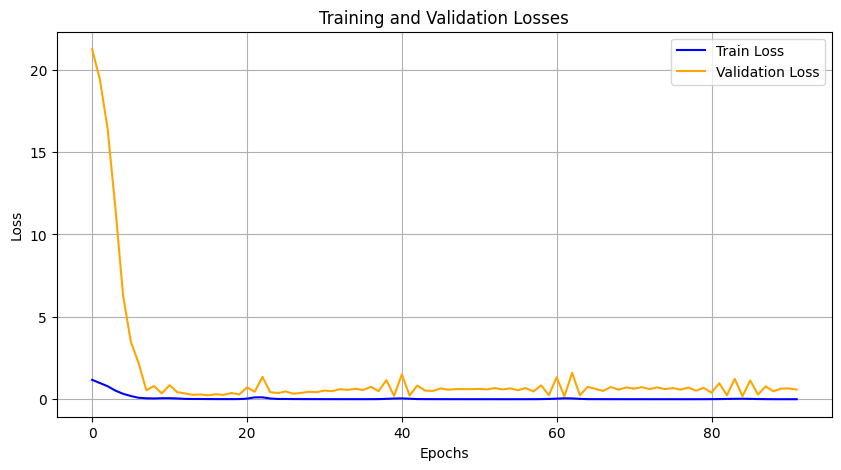

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [12]:
# Test phase
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.274766


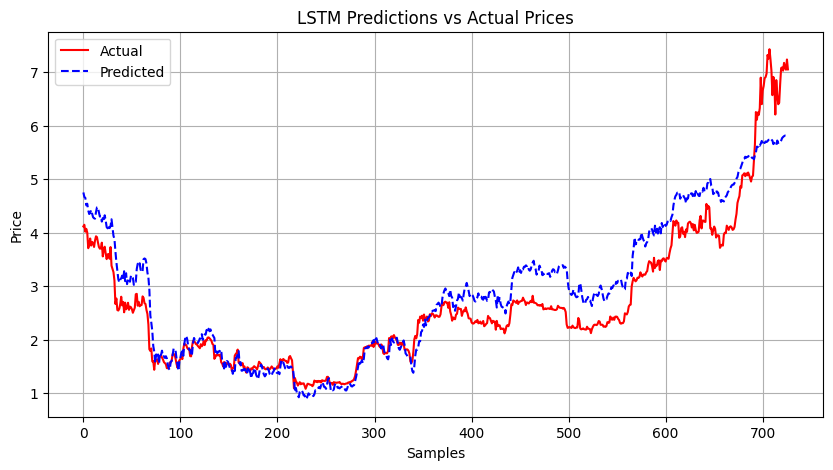

In [13]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()